In [48]:
import copy
import numpy as np
import pandas as pd
import random
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr   
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from RNN_based import MLSTM
from sklearn import preprocessing
seed_val = 0
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
plt.rc('font', family='Malgun Gothic')

In [64]:
print('numpy version : {}, pandas version : {}, pytorch version : {}'.format(np.__version__, pd.__version__, torch.__version__))

numpy version : 1.17.0, pandas version : 1.0.5, pytorch version : 1.6.0


### 0. Dataset build 함수, LSTM model training 함수

In [50]:
def build_inout_seq(input_data, train_y, seq_length):
    '''data preprocessing, create (input_train, label_train) sequences
        input_data : data set you want to train,
        seq_length : time window size, same as length of sequences, same as number of layers
        test_col : index of column you want to test, ex) 3 
        return value(inout_seq) : (input_train, output_train) by window size same as seqeunce length(seq_length)
        '''
    inout_seq = []
    L = len(input_data)
    for i in range(L - seq_length + 1):
        train_seq = input_data[i:i+seq_length]
        train_label = train_y[i+seq_length-1]
        inout_seq.append((train_seq, train_label))

    return inout_seq

def train_model(x_train, y_train, x_eval, y_eval):
    
    device = torch.device('cuda:0')
    x_train = torch.FloatTensor(x_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    x_eval = torch.FloatTensor(x_eval).to(device)
    y_eval = torch.FloatTensor(y_eval).to(device)
    
    input_dim = 12
    hidden_dim = 15
    output_dim = 1
    lr = 0.001
    epochs = 5
    seq_length = 5
    
    
    train_inout = build_inout_seq(x_train, y_train, seq_length)
    eval_inout = build_inout_seq(x_eval, y_eval, seq_length)

    model = MLSTM(input_dim, hidden_dim, seq_length, output_dim)
    model.cuda()
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    print(model)
    
    dtype = torch.FloatTensor

    predictions_train = pd.DataFrame()
    predictions_eval = pd.DataFrame()
    train_losses = []
    eval_losses = []
    
    models = {}
    
    for i in range(1, epochs+1):
        model.train()
        
        train_pred = []
        train_true = []
        eval_pred = []
        eval_true = []
        train_loss = 0
        eval_loss = 0
        for seq, label in train_inout:
            optimizer.zero_grad()
            seq = Variable(seq.view(1, seq_length, -1), requires_grad=True).to(device) #add `.to(device)` when you use gpu
            label = Variable(label.view(1, -1)).to(device) # add `.to(device)` when you use gpu
            output = model(seq)

            loss = loss_function(output, label)
            
            loss.backward(retain_graph=True)
            
            train_loss += loss.item()
            
            train_pred.append(output.detach().item())
            train_true.append(label.detach().item())
            optimizer.step()
        
        loss_mean = train_loss / len(train_inout)
        train_losses.append(loss_mean)
        predictions_train['pred_train_{}epoch'.format(i)] = train_pred
        
        
        model.eval()
        for seq, label in eval_inout:
            seq = Variable(seq).view(1, seq_length, -1).to(device)  # .to(device)
            label = Variable(label).view(1, -1).to(device)  # .to(device)
            #actuals.append(label.detach().item())

            output = model(seq)  
            eval_pred.append(output.item())
            eval_true.append(label.item())
            eval_loss += loss_function(output, label).item()  # .view(1, 1)
        loss_mean_eval = eval_loss / len(eval_inout)
        eval_losses.append(loss_mean_eval)
        predictions_eval['pred_eval_{}epoch'.format(i)] = eval_pred
        
        print('epoch {} in {}, train loss : {:.4f}, eval loss : {:.4f}'.format(i, epochs, loss_mean, loss_mean_eval))
        
        models['epoch_{}'.format(i)] = model
    predictions_train['train_true'] = train_true
    predictions_eval['eval_true'] = eval_true
    
    return (models, pd.DataFrame({'eval_losses':eval_losses, 'train_losses':train_losses}), predictions_train, predictions_eval)

## 1. Load variables to use

In [51]:
dataset = pd.read_csv('var_to_use.csv')
dataset.index = pd.to_datetime(dataset['Date'])
dataset = dataset.drop(['Date'], axis = 1)

In [52]:
dataset.head()

,불쾌지수,검색어_거리두기,감염자,age_cluster_1,age_cluster_2,age_cluster_0,area_cluster_1,area_cluster_3,area_cluster_2,area_cluster_0,코로나_단계,마스크_의무화,코로나_고위험_시설
Date,,,,,,,,,,,,,
2020-01-26,42.953416,0.00045,1,0.0,0.0,0.5,0.111111,0.0,0.0,0.0,1,3,0
2020-01-27,45.892428,0.00096,1,0.0,0.0,0.5,0.111111,0.0,0.0,0.0,6,3,1
2020-01-28,47.307743,0.00096,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,12,28,8
2020-01-29,43.756836,0.00086,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10,5,18
2020-01-30,42.877617,0.00050,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10,1,27


In [53]:
xdata = dataset.drop(['감염자'], axis = 1)
ydata = dataset[['감염자']].values

## 2.Preprocessing

In [54]:
minmax_scaler = MinMaxScaler()
xdata = minmax_scaler.fit_transform(xdata)
ydata = np.log(ydata+1)

In [55]:
xdata.shape

(242, 12)

## 3. Train 5 models for each timelag(7, 8, 9, 1, 11)

In [56]:
trained_models = []
for i in range(5):
    lag = i + 7
    xdata_ = xdata[:-(lag)]
    ydata_ = ydata[lag:]
    num_train = int(len(xdata_) * 0.95)
    x_train = xdata_[:num_train]
    x_eval = xdata_[num_train:]
    y_train = ydata_[:num_train]
    y_eval = ydata_[num_train:]

    print("\nTraining model for timelag {}...".format(lag))
    
    trained_models.append(train_model(x_train, y_train, x_eval, y_eval))    


Training model for timelag 7...
MLSTM(
  (lstm): LSTM(12, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)
epoch 1 in 5, train loss : 2.1127, eval loss : 0.1508
epoch 2 in 5, train loss : 1.0711, eval loss : 0.1383
epoch 3 in 5, train loss : 0.8040, eval loss : 0.2099
epoch 4 in 5, train loss : 0.6985, eval loss : 0.2498
epoch 5 in 5, train loss : 0.6567, eval loss : 0.2540

Training model for timelag 8...
MLSTM(
  (lstm): LSTM(12, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)
epoch 1 in 5, train loss : 2.1576, eval loss : 0.1563
epoch 2 in 5, train loss : 1.0895, eval loss : 0.1431
epoch 3 in 5, train loss : 0.8547, eval loss : 0.1887
epoch 4 in 5, train loss : 0.7520, eval loss : 0.2247
epoch 5 in 5, train loss : 0.7077, eval loss : 0.2373

Training model for timelag 9...
MLSTM(
  (lstm): LSTM(12, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)
epoch 1 in 5, train loss : 2.2039, ev

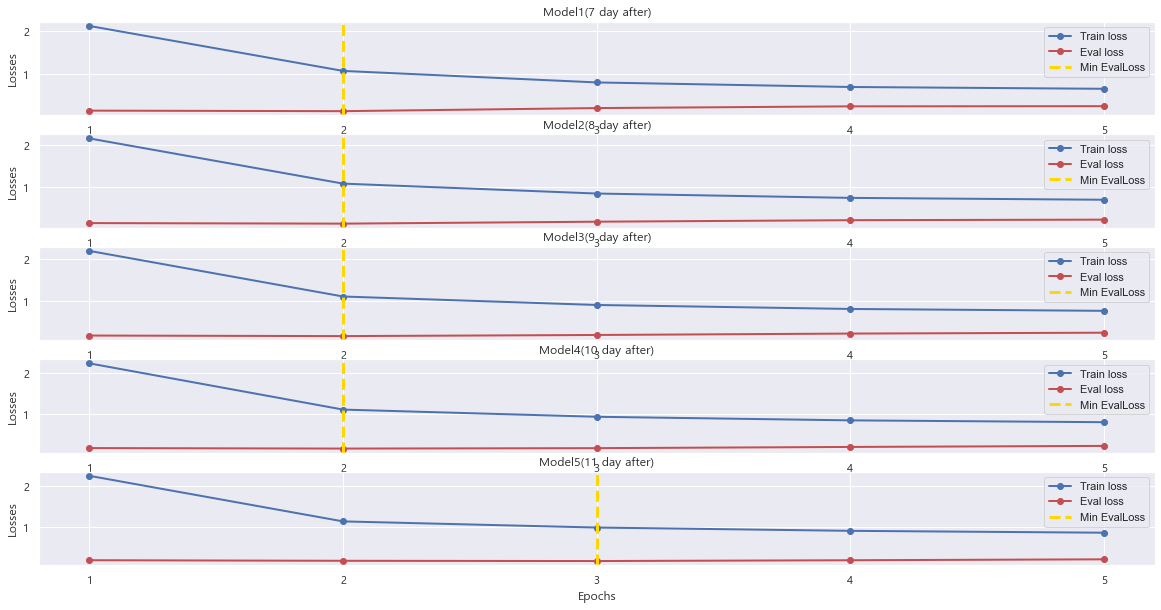

In [57]:
#show eval, train loss
%matplotlib inline
import seaborn as sns

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (20, 10))
sns.set(style='darkgrid')
for i, ax in enumerate(axes.flatten()):
    loss_data = trained_models[i][1]
    
    ax.plot(range(1, 6), loss_data['train_losses'],'b-o', label='Train loss', linewidth = 2)
    ax.plot(range(1, 6), loss_data['eval_losses'], 'r-o',label='Eval loss', linewidth = 2)
    ax.set_title('Model{}({} day after)'.format(i+1, i+7))
    ax.set_xlabel('Epochs')
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylabel('Losses')
    ax.axvline(np.argmin(trained_models[i][1]['eval_losses']) + 1, color = 'gold', linestyle = '--', label='Min EvalLoss', linewidth=3)
    ax.legend()

### ->Model 5만 3epoch 까지 학습, 나머지 모델은 2epoch까지 학습

## 4. Visualize model's train & eval

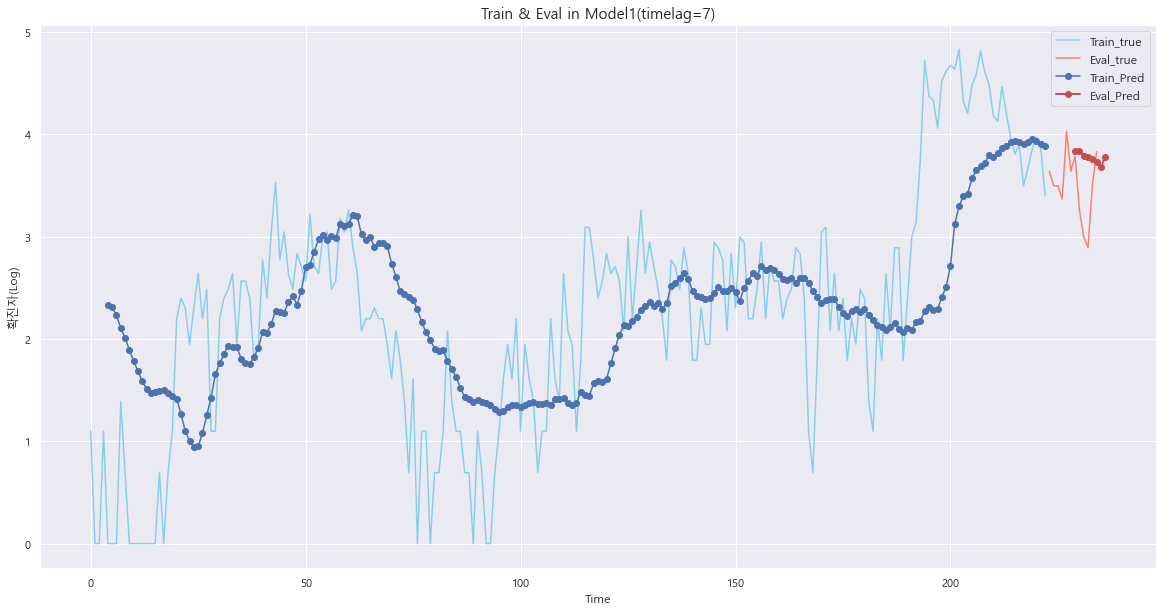

In [58]:
ydata_model1 = pd.Series(ydata[7:].flatten())
num_train = int(len(ydata_model1) * 0.95)

ydata_train_model1 = ydata_model1[:num_train]
ydata_eval_model1 = ydata_model1[num_train:]

pred_train_model1 = trained_models[0][2]['pred_train_3epoch']
pred_train_model1.index = [i+4 for i in range(219)]
pred_eval_model1 = trained_models[0][3]['pred_eval_3epoch']
pred_eval_model1.index = [i+229 for i in range(8)]

plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20, 10))
plt.plot(ydata_train_model1.index, ydata_train_model1, color = 'skyblue', label = 'Train_true')
plt.plot(ydata_eval_model1.index, ydata_eval_model1, color = 'salmon', label = 'Eval_true')
plt.plot(pred_train_model1.index, pred_train_model1, 'b-o',label = 'Train_Pred')
plt.plot(pred_eval_model1.index, pred_eval_model1, 'r-o', label = 'Eval_Pred', linewidth = 2)
plt.legend(loc='best', fontsize='medium')
plt.xlabel('Time')
plt.ylabel('확진자(Log)')
plt.title("Train & Eval in Model1(timelag=7)", fontsize=15)
plt.show()

## 5. Prediction

In [59]:
seq_length = 5
final_models = []
for model_num in range(5):
    if model_num == 4:
        final_models.append(trained_models[model_num][0]['epoch_3'])
    else:
        final_models.append(trained_models[model_num][0]['epoch_2'])
input_for_pred = torch.FloatTensor(xdata[-seq_length:]).to('cuda')
seq = Variable(input_for_pred.view(1, seq_length, -1), requires_grad=False).to('cuda')

In [61]:
#model save
for i, model in enumerate(final_models):
    torch.save(model.state_dict(), './Best_models/model_{}'.format(i+1))

In [60]:
preds = np.exp([model(seq).item() for model in final_models])
start = pd.to_datetime('2020-09-30')
for i, pred in enumerate(preds):
    print('{} 일의 확진자 예측 : {}'.format((start+timedelta(days = i)).date(), int(round(pred))))

2020-09-30 일의 확진자 예측 : 37
2020-10-01 일의 확진자 예측 : 36
2020-10-02 일의 확진자 예측 : 34
2020-10-03 일의 확진자 예측 : 33
2020-10-04 일의 확진자 예측 : 32
